This is to test TTS models with benchmark sentences for speech synthesis.

Before running this script please DON'T FORGET: 
- to set file paths.
- to download related model files from TTS and WaveRNN.
- to checkout right commit versions (given next to the model) of TTS and WaveRNN.
- to set the right paths in the cell below.

Repositories:
- TTS: https://github.com/mozilla/TTS
- WaveRNN: https://github.com/erogol/WaveRNN

In [1]:
TTS_PATH = "/search/hadoop02/suanfa/wuzijun/"
WAVEGAN_PATH ="/search/hadoop02/suanfa/wuzijun/ParallelWaveGAN/"

In [2]:
%load_ext autoreload
%autoreload 2
import os
import sys
import io
import torch 
import time
import json
import numpy as np
import yaml
from collections import OrderedDict
from matplotlib import pylab as plt

%pylab inline
rcParams["figure.figsize"] = (16,5)

# add libraries into environment
sys.path.append(TTS_PATH) # set this if TTS is not installed globally
sys.path.append(WAVEGAN_PATH) # set this if TTS is not installed globally

import librosa
import librosa.display

from TTS.models.tacotron2 import Tacotron2
from TTS.layers import *
from TTS.utils.data import *
from TTS.utils.audio import AudioProcessor
from TTS.utils.generic_utils import load_config, setup_model
from TTS.utils.text import text_to_sequence
from TTS.utils.synthesis import synthesis, synthesis2
from TTS.utils.visual import visualize
from ParallelWaveGAN.parallel_wavegan.models import ParallelWaveGANGenerator
from ParallelWaveGAN.parallel_wavegan.utils.audio import AudioProcessor as AudioProcessor_v

import IPython
from IPython.display import Audio

import os
os.environ['CUDA_VISIBLE_DEVICES']='1'

Populating the interactive namespace from numpy and matplotlib


/search/hadoop02/suanfa/anaconda3/envs/tacotron2/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [50]:
# Set constants
# new Biaobei-December-11-2019_08+24AM-536ef91
# old Biaobei-November-29-2019_07+21AM-649312f
ROOT_PATH = '../../../TTS/output/Biaobei-December-11-2019_08+24AM-536ef91/'
MODEL_PATH = ROOT_PATH + '/best_model.pth.tar'
CONFIG_PATH = '../../../TTS/config.json'
OUT_FOLDER = '../output/benchmark_samples/'
CONFIG = load_config(CONFIG_PATH)
VOCODER_MODEL_PATH = "../output/checkpoint-200000steps.pkl"
VOCODER_CONFIG_PATH = "../tts_config.yaml"
VOCODER_CONFIG = yaml.load(open(VOCODER_CONFIG_PATH), Loader=yaml.Loader)
use_cuda = True

ap_vocoer = AudioProcessor_v(**VOCODER_CONFIG['audio'])

# Set some config fields manually for testing
CONFIG.windowing = False
CONFIG.prenet_dropout = True
CONFIG.separate_stopnet = True
CONFIG.use_forward_attn = False
CONFIG.forward_attn_mask = False
CONFIG.stopnet = True

# Set the vocoder
use_gl = False # use GL if True
# batched_wavernn = True    # use batched wavernn inference if True

 > Setting up Audio Processor...
 | > sample_rate:48000
 | > num_mels:80
 | > min_level_db:-100
 | > frame_shift_ms:12.5
 | > frame_length_ms:50
 | > ref_level_db:20
 | > num_freq:2049
 | > power:None
 | > preemphasis:0.0
 | > griffin_lim_iters:None
 | > signal_norm:True
 | > symmetric_norm:True
 | > mel_fmin:125.0
 | > mel_fmax:7600.0
 | > max_norm:4.0
 | > clip_norm:True
 | > do_trim_silence:True
 | > sound_norm:True
 | > n_fft:4096
 | > hop_length:600
 | > win_length:2400


In [51]:
# LOAD TTS MODEL
from TTS.utils.text.symbols import symbols, phonemes

# multi speaker 
if CONFIG.use_speaker_embedding:
    speakers = json.load(open(f"{ROOT_PATH}/speakers.json", 'r'))
    speakers_idx_to_id = {v: k for k, v in speakers.items()}
else:
    speakers = []
    speaker_id = None

# load the model
num_chars = len(phonemes) if CONFIG.use_phonemes else len(symbols)
model = setup_model(num_chars, len(speakers), CONFIG)

# load the audio processor
ap = AudioProcessor(**CONFIG.audio)         


# load model state
if use_cuda:
    cp = torch.load(MODEL_PATH)
else:
    cp = torch.load(MODEL_PATH, map_location=lambda storage, loc: storage)

# load the model
model.load_state_dict(cp['model'])
if use_cuda:
    model.cuda()
model.eval()
print(cp['step'])
print(cp['r'])

# set model stepsize
if 'r' in cp:
    model.decoder.set_r(cp['r'])

 > Using model: Tacotron2
 > Setting up Audio Processor...
 | > sample_rate:48000
 | > num_mels:80
 | > min_level_db:-100
 | > frame_shift_ms:12.5
 | > frame_length_ms:50
 | > ref_level_db:20
 | > num_freq:2049
 | > power:1.5
 | > preemphasis:0.98
 | > griffin_lim_iters:60
 | > signal_norm:True
 | > symmetric_norm:True
 | > mel_fmin:125.0
 | > mel_fmax:7600.0
 | > max_norm:4.0
 | > clip_norm:True
 | > do_trim_silence:True
 | > sound_norm:False
 | > n_fft:4096
 | > hop_length:600
 | > win_length:2400
80650
1


In [5]:
def unwrap_distributed(state_dict):
    """
    Unwraps model from DistributedDataParallel.
    DDP wraps model in additional "module.", it needs to be removed for single
    GPU inference.
    :param state_dict: model's state dict
    """
    new_state_dict = {}
    for key, value in state_dict.items():
        new_key = key.replace('module.', '')
        new_state_dict[new_key] = value
    return new_state_dict

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [7]:
# LOAD WAVEGAN
if use_gl == False:    
    wavegan = ParallelWaveGANGenerator(**VOCODER_CONFIG["generator_params"])
    wavegan.load_state_dict(unwrap_distributed(torch.load(VOCODER_MODEL_PATH, map_location="cpu")["model"]["generator"]))
    wavegan.remove_weight_norm()
    wavegan = wavegan.eval().to(device)

In [8]:
hop_size = 600

In [9]:
def wavegan_generate(model, c, config=VOCODER_CONFIG):
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    pad_size = (config["generator_params"]["aux_context_window"],
                config["generator_params"]["aux_context_window"])
    with torch.no_grad():
        z = torch.randn(1, 1, c.shape[0] * hop_size).to(device)
        c = np.pad(c, (pad_size, (0, 0)), "edge")
        c = torch.FloatTensor(c).unsqueeze(0).transpose(2, 1).to(device)
        start = time.time()
        # print(start)
        y = model(z, c).view(-1).cpu().numpy()
        rft = (time.time() - start)
        print(f"WaveGAN time: {rft}")
        return y

In [10]:
def tts2(model_tts, model_vocoder, text, CONFIG, use_cuda, ap, ap_vocoer, CONFIG_VOCODER, use_gl, figures=False, create_gl=False):
    t_1 = time.time()
    wave_gl, alignment, mel_spec, mel_postnet_spec, stop_tokens = synthesis2(model_tts, text, CONFIG, use_cuda, ap, speaker_id, False, CONFIG.enable_eos_bos_chars, do_trim_silence=False, create_gl=create_gl)
    if CONFIG.model == "Tacotron" and not use_gl:
        # coorect the normalization differences b/w TTS and the Vocoder.
        mel_postnet_spec = ap.out_linear_to_mel(mel_postnet_spec.T).T
    mel_postnet_spec = ap._denormalize(mel_postnet_spec)
    mel_postnet_spec = ap_vocoer._normalize(mel_postnet_spec)
    print(" > Tacotron2-time: {}".format(time.time() - t_1))
    # print(mel_postnet_spec.shape)
    if not use_gl:
        waveform = wavegan_generate(model_vocoder, 
                                    mel_postnet_spec,
                                    CONFIG_VOCODER
                                   )
        # waveform = wavernn.generate(mel_postnet_spec.T.unsqueeze(0).cuda(), batched=batched_wavernn, target=3000, overlap=100, ap=ap_vocoder)
    print("\n >  Run-time: {}".format(time.time() - t_1))
    if figures:                                                                                                         
        visualize(alignment, mel_postnet_spec, stop_tokens, text, ap.hop_length, CONFIG, mel_spec)
    if create_gl:
        IPython.display.display(Audio(wave_gl, rate=CONFIG.audio['sample_rate']))
    IPython.display.display(Audio(waveform, rate=CONFIG.audio['sample_rate']))  
    os.makedirs(OUT_FOLDER, exist_ok=True)
    file_name = text.replace(" ", "_").replace(".","") + ".wav"
    out_path = os.path.join(OUT_FOLDER, file_name)
    ap.save_wav(waveform, out_path)
    return alignment, mel_postnet_spec, stop_tokens, waveform

### Comparision with https://mycroft.ai/blog/available-voices/

 > Tacotron2-time: 1.4684317111968994
WaveGAN time: 0.28902292251586914

 >  Run-time: 1.8937766551971436


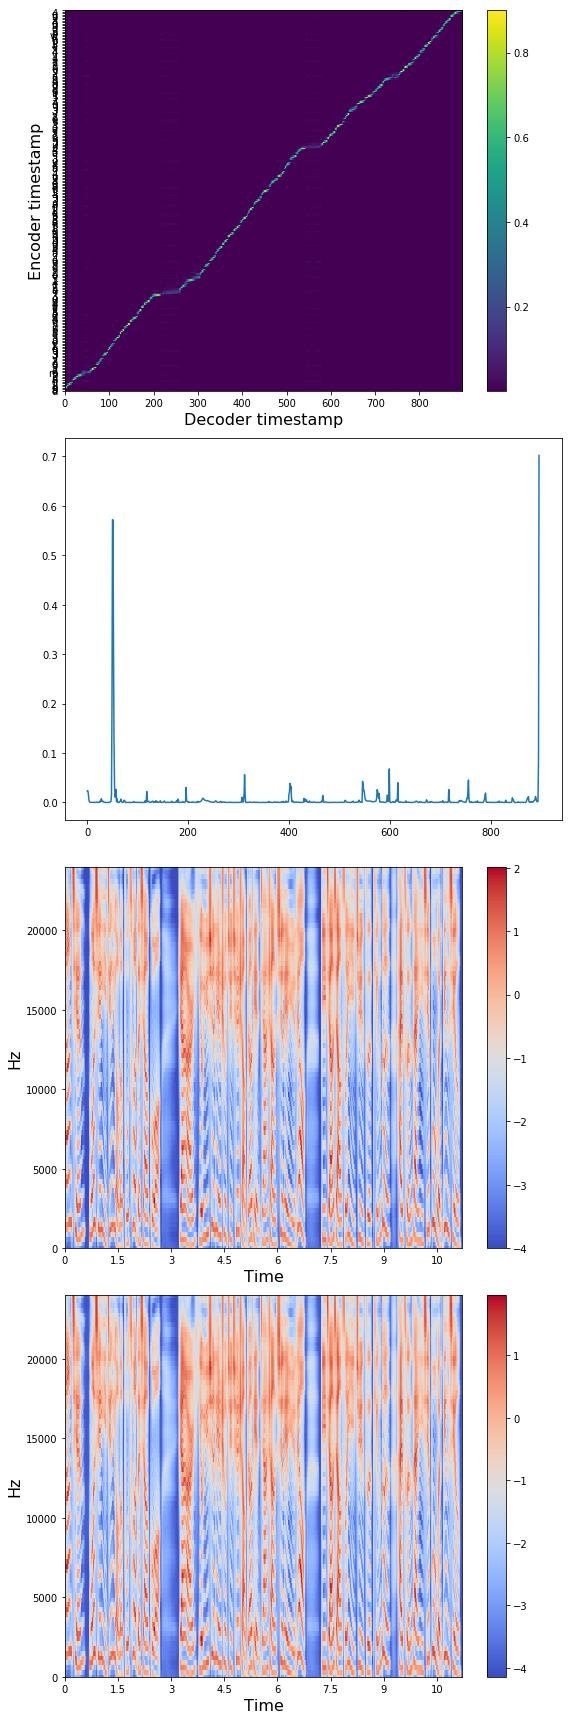

In [72]:
model.eval()
model.decoder.max_decoder_steps = 2000
speaker_id = None
sentence =  "dang1 qian2 mo2 xing2 yi3 jing1 you3 le5 bu2 cuo4 de5 xiao4 guo3. ran2 er2, you2 yu2 xun4 lian4 shu4 ju4 que1 shao3 biao1 dian3, jia1 shang4 xun4 lian4 yu3 liao4 bi2 jiao2 xiao3, suo2 yi3, ju4 zi5 ting2 dun4 hai2 cun2 zai4 yi4 xie1 bu4 wen3 ding4 xing4."
align, spec, stop_tokens, wav = tts2(model, wavegan, sentence, CONFIG, use_cuda, ap, ap_vocoer, VOCODER_CONFIG, use_gl=use_gl, figures=True, create_gl=False)

 > Tacotron2-time: 1.7189373970031738
WaveGAN time: 0.21476078033447266

 >  Run-time: 1.9402062892913818


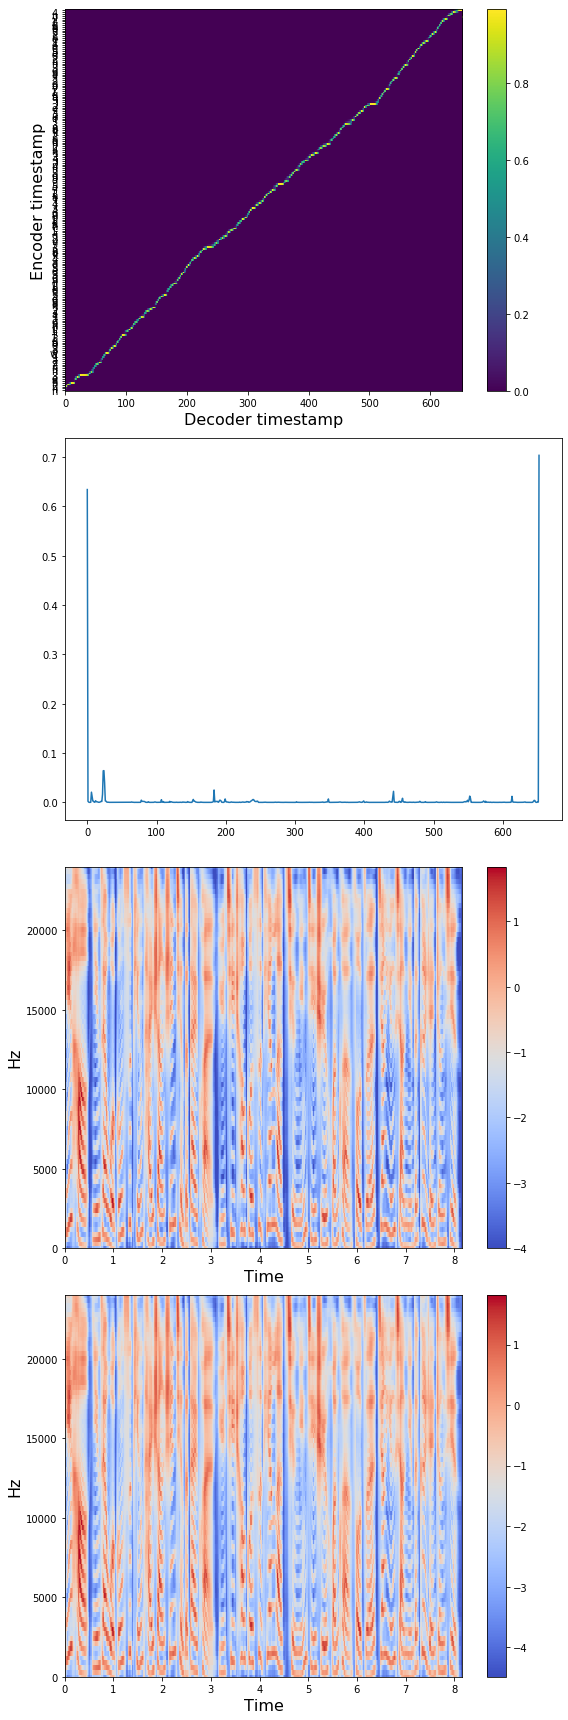

In [36]:
model.eval()
model.decoder.max_decoder_steps = 2000
speaker_id = None
sentence =  "nin2 hao3, nin2 zai4 wo3 gong1 si1 ping2 tai2 shang4 shen1 qing3 de5 dai4 kuan3, yu2 qi1 chao1 guo4 si4 tian1 le5, qing3 nin2 ji2 shi2 huan2 kuan3, fou3 ze2, jiang1 ying2 xiang3 nin2 de5 ge4 ren2 zheng1 xin4."
align, spec, stop_tokens, wav = tts2(model, wavegan, sentence, CONFIG, use_cuda, ap, ap_vocoer, VOCODER_CONFIG, use_gl=use_gl, figures=True, create_gl=False)

In [316]:
model.eval()
model.decoder.max_decoder_steps = 2000
speaker_id = None
sentence =  "nin2 hao3,, qing3 wen4nin2 shi4?"
align, spec, stop_tokens, wav1 = tts2(model, wavegan, sentence, CONFIG, use_cuda, ap, ap_vocoer, VOCODER_CONFIG, use_gl=use_gl, figures=False, create_gl=False)

 > Tacotron2-time: 0.25185203552246094
WaveGAN time: 0.05365586280822754

 >  Run-time: 0.3073697090148926


In [283]:
model.eval()
model.decoder.max_decoder_steps = 2000
speaker_id = None
sentence =  "wu2 zi3 jun4"
align, spec, stop_tokens, wav2 = tts2(model, wavegan, sentence, CONFIG, use_cuda, ap, ap_vocoer, VOCODER_CONFIG, use_gl=use_gl, figures=False, create_gl=False)

 > Tacotron2-time: 0.10493588447570801
WaveGAN time: 0.023484468460083008

 >  Run-time: 0.12952327728271484


In [220]:
model.eval()
model.decoder.max_decoder_steps = 2000
speaker_id = None
sentence =  "xian1 sheng5 me5"
align, spec, stop_tokens, wav3 = tts2(model, wavegan, sentence, CONFIG, use_cuda, ap, ap_vocoer, VOCODER_CONFIG, use_gl=use_gl, figures=False, create_gl=False)

 > Tacotron2-time: 0.25340962409973145
WaveGAN time: 0.07344579696655273

 >  Run-time: 0.3638918399810791


In [296]:
model.eval()
model.decoder.max_decoder_steps = 2000
speaker_id = None
sentence =  "wu2 zi3 jun4xian5 sheng5 me5"
align, spec, stop_tokens, wav4 = tts2(model, wavegan, sentence, CONFIG, use_cuda, ap, ap_vocoer, VOCODER_CONFIG, use_gl=use_gl, figures=False, create_gl=False)

 > Tacotron2-time: 0.3479747772216797
WaveGAN time: 0.03592228889465332

 >  Run-time: 0.38654351234436035


In [73]:
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

In [221]:
wav = np.concatenate((wav1, wav2, wav3), axis=None)

In [239]:
wav_silence = librosa.effects.split(wav, top_db=15)

In [240]:
wav_new = np.concatenate([wav[i[0]: i[1]] for i in wav_silence], axis=None)

In [241]:
IPython.display.display(Audio(wav_new, rate=48000))

In [317]:
wav2 = np.concatenate((wav1, wav4), axis=None)

In [318]:
wav_silence2 = librosa.effects.split(wav2, top_db=25)

In [319]:
wav_new2 = np.concatenate([wav2[i[0]: i[1]] for i in wav_silence2], axis=None)

In [320]:
IPython.display.display(Audio(wav_new2, rate=48000))

In [323]:
model.eval()
model.decoder.max_decoder_steps = 2000
speaker_id = None
sentence =  "nin2 hao3,,qing3 wen4 nin2shi4 wu2zi3 jun4xian1sheng5 me5"
align, spec, stop_tokens, wav2 = tts2(model, wavegan, sentence, CONFIG, use_cuda, ap, ap_vocoer, VOCODER_CONFIG, use_gl=use_gl, figures=False, create_gl=False)

 > Tacotron2-time: 0.4028630256652832
WaveGAN time: 0.07971405982971191

 >  Run-time: 0.4853630065917969


In [324]:
import torch

In [325]:
import torch.nn as nn

In [326]:
np.argsort([1,43,5,7,89])

array([0, 2, 3, 1, 4])

In [330]:
np.argsort([1,43,5,7,89])[::-1]

array([4, 1, 3, 2, 0])